# COMPARING BASELINE TO THIS APPROACH

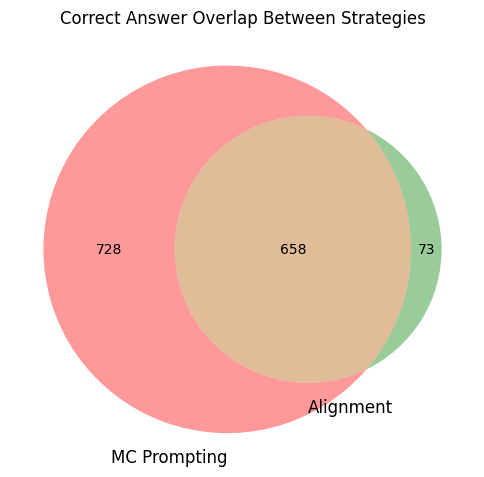

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# === Load both results ===
mc_df = pd.read_csv("output/cot.csv")
align_df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# === Preprocess ===
mc_df["Predicted"] = mc_df["Predicted"].str.strip().str.upper()
mc_df["OriginalCorrect"] = mc_df["OriginalCorrect"].str.strip().str.upper()
align_df["Predicted"] = align_df["Predicted"].str.strip().str.upper()
align_df["CorrectAnswer"] = align_df["CorrectAnswer"].str.strip().str.upper()

# === Merge on question index ===
mc_df["OriginalIndex"] = mc_df.index
merged = pd.merge(mc_df, align_df, on="OriginalIndex", suffixes=("_MC", "_Align"))

# === Evaluate Accuracy ===
merged["MC_Correct"] = merged["Predicted_MC"] == merged["OriginalCorrect"]
merged["Align_Correct"] = merged["Predicted_Align"] == merged["CorrectAnswer"]

# === Set counts for Venn
only_mc = ((merged["MC_Correct"]) & (~merged["Align_Correct"])).sum()
only_align = ((merged["Align_Correct"]) & (~merged["MC_Correct"])).sum()
both = ((merged["MC_Correct"]) & (merged["Align_Correct"])).sum()

# === Plot Venn Diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(only_mc, only_align, both), set_labels=("MC Prompting", "Alignment"))
plt.title("Correct Answer Overlap Between Strategies")
plt.show()


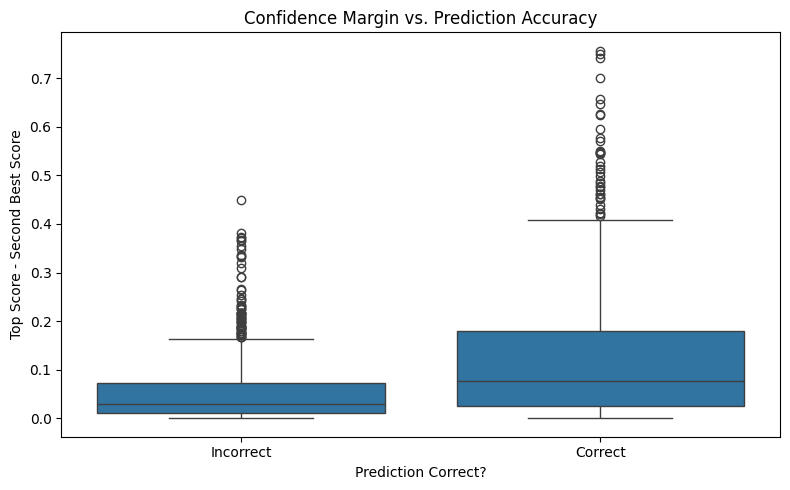

Average Confidence Margin (Correct): 0.1259993921911851
Average Confidence Margin (Incorrect): 0.05316839908788863


In [15]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your output file ===
df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# === Normalize columns ===
df["Predicted"] = df["Predicted"].str.strip().str.upper()
df["CorrectAnswer"] = df["CorrectAnswer"].str.strip().str.upper()
df["IsCorrect"] = df["Predicted"] == df["CorrectAnswer"]

# === Parse Similarity Scores ===
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)

# === Compute metrics ===
df["TopScore"] = df["SimilarityScores"].apply(max)
df["TopIndex"] = df["SimilarityScores"].apply(lambda s: s.index(max(s)))
df["SecondScore"] = df["SimilarityScores"].apply(lambda s: sorted(s, reverse=True)[1])
df["ConfidenceMargin"] = df["TopScore"] - df["SecondScore"]

# === Distribution of Confidence by Correctness ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="IsCorrect", y="ConfidenceMargin")
plt.title("Confidence Margin vs. Prediction Accuracy")
plt.xlabel("Prediction Correct?")
plt.ylabel("Top Score - Second Best Score")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.tight_layout()
plt.show()

# === Optional: Print correlation
print("Average Confidence Margin (Correct):", df[df["IsCorrect"] == True]["ConfidenceMargin"].mean())
print("Average Confidence Margin (Incorrect):", df[df["IsCorrect"] == False]["ConfidenceMargin"].mean())


In [16]:
threshold = 0.4524092674256
confident = df[df["ConfidenceMargin"] > threshold]
print("Accuracy on confident predictions:", confident["IsCorrect"].mean())
print("Coverage (fraction of data kept):", len(confident) / len(df))
print(len(confident))


Accuracy on confident predictions: 1.0
Coverage (fraction of data kept): 0.01764705882352941
30


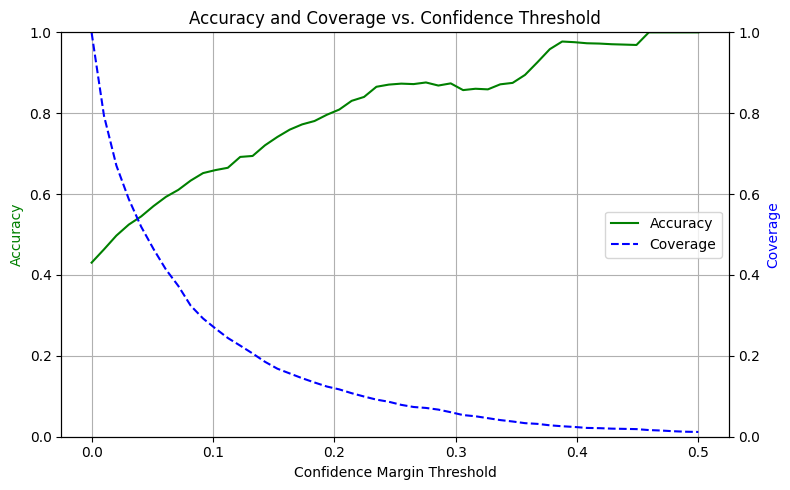

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of thresholds
thresholds = np.linspace(0, 0.5, 50)
accuracies = []
coverages = []

for t in thresholds:
    confident = df[df["ConfidenceMargin"] > t]
    if len(confident) == 0:
        acc = np.nan
    else:
        acc = confident["IsCorrect"].mean()
    accuracies.append(acc)
    coverages.append(len(confident) / len(df))

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax2 = ax1.twinx()
ax1.plot(thresholds, accuracies, color='green', label="Accuracy")
ax2.plot(thresholds, coverages, color='blue', linestyle='--', label="Coverage")

ax1.set_xlabel("Confidence Margin Threshold")
ax1.set_ylabel("Accuracy", color='green')
ax2.set_ylabel("Coverage", color='blue')

# Set both y-axis limits to 0–1.0
ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)

ax1.set_title("Accuracy and Coverage vs. Confidence Threshold")
ax1.grid(True)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()


In [29]:
# Set your accuracy threshold
target_accuracy = 1 #0.8152941176470588

# Find the first threshold where accuracy >= target
for t, acc, cov in zip(thresholds, accuracies, coverages):
    if acc is not None and acc >= target_accuracy:
        num_values = int(cov * len(df))
        pct_values = cov
        print(f"Threshold: {t:.3f}")
        print(f"Number of values above threshold: {num_values}")
        print(f"Percentage of values: {pct_values:.2%}")
        break
else:
    print("No threshold found where accuracy >= 80%")


Threshold: 0.459
Number of values above threshold: 28
Percentage of values: 1.65%


In [18]:
import pandas as pd
import ast

# Load your CSV (replace this with your actual filename)
df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# Parse stringified similarity scores into lists
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)

# Function to compute gap between highest and second highest similarity
def get_gap(row):
    scores = row["SimilarityScores"]
    sorted_scores = sorted(scores, reverse=True)
    return sorted_scores[0] - sorted_scores[1]

# Apply the gap calculation
df["TopScoreGap"] = df.apply(get_gap, axis=1)

# Find the row with the maximum gap
best_row = df.loc[df["TopScoreGap"].idxmax()]
print(best_row.to_string())


OriginalIndex                                                     173
Predicted                                                           C
CorrectAnswer                                                       C
SimilarityScores    [0.09587089717388153, 0.09870736300945282, 0.8...
FreeResponse                                   Social Media Marketing
A                                                 Pay per click (PPC)
B                                    Digital asset optimization (DAO)
C                                        Social media marketing (SMM)
D                                    Search engine optimization (SEO)
Question            ____________ is a form of digital marketing th...
Subject                                                     marketing
Subcategory                                                  business
TopScoreGap                                                  0.756465


In [19]:
row = df.loc[df["TopScoreGap"].idxmax()]

# Print formatted blocks
print("🧪 **QUESTION**")
print(row["Question"])
print()

print("📋 **ANSWER CHOICES**")
print(f"A) {row['A']}")
print(f"B) {row['B']}")
print(f"C) {row['C']}")
print(f"D) {row['D']}")
print()

print("✅ **CORRECT ANSWER**")
print(f"{row['CorrectAnswer']}) {row[row['CorrectAnswer']]}")
print()

print("🤖 **MODEL PREDICTION**")
print(f"{row['Predicted']}) {row[row['Predicted']]}")
print()

print("🧠 **FREE RESPONSE**")
print(row["FreeResponse"])
print()

print("📈 **SIMILARITY SCORES**")
for label, score in zip(["A", "B", "C", "D"], row["SimilarityScores"]):
    print(f"{label}: {score:.4f}")
print()

print("📊 **Top Score Gap**")
print(f"{row['TopScoreGap']:.6f}")


🧪 **QUESTION**
____________ is a form of digital marketing that describes the use of the social web and social media (e.g. social networks, online communities, blogs or wikis) or any online collaborative technology for marketing activities, be it sales, public relations, research, distribution, or customer service.

📋 **ANSWER CHOICES**
A) Pay per click (PPC)
B) Digital asset optimization (DAO)
C) Social media marketing (SMM)
D) Search engine optimization (SEO)

✅ **CORRECT ANSWER**
C) Social media marketing (SMM)

🤖 **MODEL PREDICTION**
C) Social media marketing (SMM)

🧠 **FREE RESPONSE**
Social Media Marketing

📈 **SIMILARITY SCORES**
A: 0.0959
B: 0.0987
C: 0.8552
D: 0.0415

📊 **Top Score Gap**
0.756465


# MISTRAL THINGS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('output/alignment_eval_mistral-small_en.csv')

In [3]:
df.head()

,OriginalIndex,Predicted,CorrectAnswer,SimilarityScores,FreeResponse,A,B,C,D,Question,Subject,Subcategory
0,0,A,B,"[0.7602895498275757, 0.7509633302688599, 0.588...",Humans and chimpanzees share a more recent com...,humans and dogs are more closely related than ...,humans and chimpanzees are more closely relate...,humans are related to chimpanzees but not to dogs,humans and chimpanzees are closely analogous,The sequence of amino acids in hemoglobin mole...,high_school_biology,biology
1,1,D,A,"[0.23034070432186127, 0.15103930234909058, 0.1...","To provide an accurate answer, I need more con...",Ontogeny recapitulates phylogeny.,Early embryos display identical features of th...,An early human embryo has features in common w...,A human embryo displays features of adult fish...,An embryologist studying the development of a ...,college_biology,biology
2,2,B,D,"[0.045140426605939865, 0.09170043468475342, 0....","To provide a precise answer, I need to know wh...",the potential mates experience geographic isol...,the potential mates experience behavioral isol...,the potential mates have different courtship r...,the potential mates have similar breeding seasons,All of the following are examples of events th...,high_school_biology,biology
3,3,A,A,"[-0.06882953643798828, -0.09942945837974548, -...","To answer this accurately, I need to know the ...",It occurs randomly.,A particular cell dies when it is no longer ne...,A cell carries out apoptosis when too many mut...,Plant cells carry out apoptosis as a defense m...,"Apoptosis, which is programmed cell death, is ...",high_school_biology,biology
4,4,C,B,"[0.13758346438407898, 0.18974103033542633, 0.3...",The observations support the idea of genetic l...,Evolution is progressive and tends toward a mo...,Phenotype is often the result of compromise.,Natural selection reduces the frequency of mal...,Polygenic inheritance is generally maladaptive...,The same gene that causes various coat pattern...,high_school_biology,biology


In [4]:
correct_df = df[df['Predicted'] == df['CorrectAnswer']]

In [6]:
correct_df.shape[0] / 1700

0.43

# gap

In [22]:
df = pd.read_csv('output/cot.csv')

In [24]:
df.head()

,Unnamed: 0,OriginalIndex,RotationPosition,OriginalCorrect,Question,A,B,C,D,Predicted,RawOutput,Subject,Subcategory
0,1,0,B,B,The sequence of amino acids in hemoglobin mole...,humans and dogs are more closely related than ...,humans and chimpanzees are more closely relate...,humans are related to chimpanzees but not to dogs,humans and chimpanzees are closely analogous,B,"To determine the correct answer, let's break d...",high_school_biology,biology
1,4,1,A,A,An embryologist studying the development of a ...,Ontogeny recapitulates phylogeny.,Early embryos display identical features of th...,An early human embryo has features in common w...,A human embryo displays features of adult fish...,C,To determine which conclusion an embryologist ...,college_biology,biology
2,11,2,D,D,All of the following are examples of events th...,the potential mates experience geographic isol...,the potential mates experience behavioral isol...,the potential mates have different courtship r...,the potential mates have similar breeding seasons,D,To determine which option is NOT an example of...,high_school_biology,biology
3,12,3,A,A,"Apoptosis, which is programmed cell death, is ...",It occurs randomly.,A particular cell dies when it is no longer ne...,A cell carries out apoptosis when too many mut...,Plant cells carry out apoptosis as a defense m...,A,To determine which statement is NOT correct ab...,high_school_biology,biology
4,17,4,B,B,The same gene that causes various coat pattern...,Evolution is progressive and tends toward a mo...,Phenotype is often the result of compromise.,Natural selection reduces the frequency of mal...,Polygenic inheritance is generally maladaptive...,B,To determine which statement is supported by t...,high_school_biology,biology


In [25]:
df_correct = df[df['OriginalCorrect'] == df['Predicted']]

In [27]:
df_correct.shape[0] / 1700

0.8152941176470588

In [31]:
df2 = pd.read_csv('output/alignment_eval_mistral-small_en.csv')

In [32]:
df2.head()

,OriginalIndex,Predicted,CorrectAnswer,SimilarityScores,FreeResponse,A,B,C,D,Question,Subject,Subcategory
0,0,A,B,"[0.7602895498275757, 0.7509633302688599, 0.588...",Humans and chimpanzees share a more recent com...,humans and dogs are more closely related than ...,humans and chimpanzees are more closely relate...,humans are related to chimpanzees but not to dogs,humans and chimpanzees are closely analogous,The sequence of amino acids in hemoglobin mole...,high_school_biology,biology
1,1,D,A,"[0.23034070432186127, 0.15103930234909058, 0.1...","To provide an accurate answer, I need more con...",Ontogeny recapitulates phylogeny.,Early embryos display identical features of th...,An early human embryo has features in common w...,A human embryo displays features of adult fish...,An embryologist studying the development of a ...,college_biology,biology
2,2,B,D,"[0.045140426605939865, 0.09170043468475342, 0....","To provide a precise answer, I need to know wh...",the potential mates experience geographic isol...,the potential mates experience behavioral isol...,the potential mates have different courtship r...,the potential mates have similar breeding seasons,All of the following are examples of events th...,high_school_biology,biology
3,3,A,A,"[-0.06882953643798828, -0.09942945837974548, -...","To answer this accurately, I need to know the ...",It occurs randomly.,A particular cell dies when it is no longer ne...,A cell carries out apoptosis when too many mut...,Plant cells carry out apoptosis as a defense m...,"Apoptosis, which is programmed cell death, is ...",high_school_biology,biology
4,4,C,B,"[0.13758346438407898, 0.18974103033542633, 0.3...",The observations support the idea of genetic l...,Evolution is progressive and tends toward a mo...,Phenotype is often the result of compromise.,Natural selection reduces the frequency of mal...,Polygenic inheritance is generally maladaptive...,The same gene that causes various coat pattern...,high_school_biology,biology


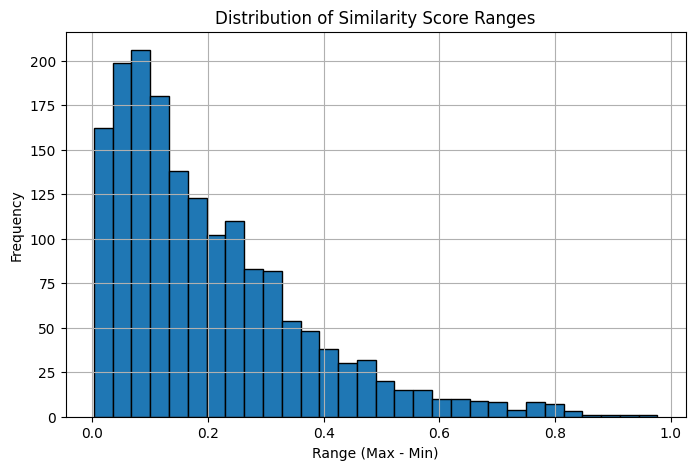

In [33]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# If not already loaded
# df2 = pd.read_csv("your_file.csv")

# Parse similarity scores from string to list and compute the range
df2['SimilarityRange'] = df2['SimilarityScores'].apply(lambda x: max(ast.literal_eval(x)) - min(ast.literal_eval(x)))

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(df2['SimilarityRange'], bins=30, edgecolor='black')
plt.title('Distribution of Similarity Score Ranges')
plt.xlabel('Range (Max - Min)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


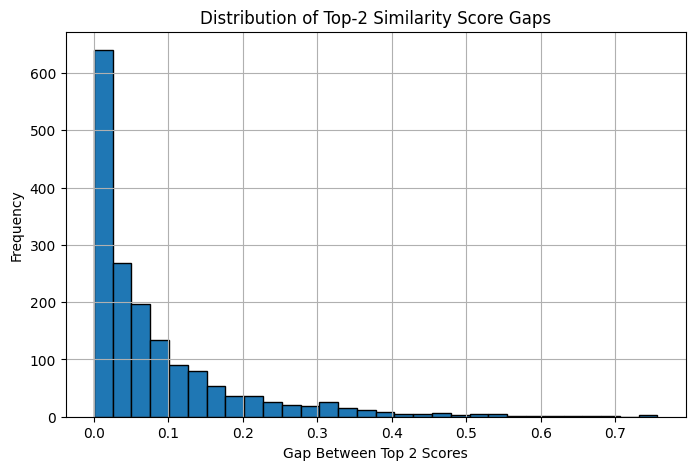

In [34]:
df2['Top2Gap'] = df2['SimilarityScores'].apply(lambda x: 
    sorted(ast.literal_eval(x), reverse=True)[0] - sorted(ast.literal_eval(x), reverse=True)[1]
)

plt.figure(figsize=(8, 5))
plt.hist(df2['Top2Gap'], bins=30, edgecolor='black')
plt.title('Distribution of Top-2 Similarity Score Gaps')
plt.xlabel('Gap Between Top 2 Scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<Figure size 700x500 with 0 Axes>

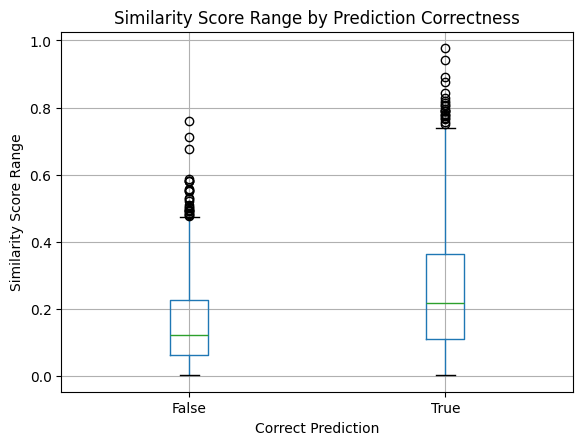

In [35]:
df2['IsCorrect'] = df2['Predicted'] == df2['CorrectAnswer']
df2['SimilarityRange'] = df2['SimilarityScores'].apply(lambda x: max(ast.literal_eval(x)) - min(ast.literal_eval(x)))

plt.figure(figsize=(7, 5))
df2.boxplot(column='SimilarityRange', by='IsCorrect')
plt.title('Similarity Score Range by Prediction Correctness')
plt.suptitle('')
plt.xlabel('Correct Prediction')
plt.ylabel('Similarity Score Range')
plt.grid(True)
plt.show()


In [36]:
from scipy.stats import ttest_ind

correct_ranges = df2[df2['IsCorrect']]['SimilarityRange']
incorrect_ranges = df2[~df2['IsCorrect']]['SimilarityRange']

t_stat, p_value = ttest_ind(correct_ranges, incorrect_ranges, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")


T-statistic: 12.1596, p-value: 0.0000


In [38]:
import statsmodels.api as sm

# Logistic regression model: IsCorrect ~ SimilarityRange
X = sm.add_constant(df2['SimilarityRange'])
y = df2['IsCorrect'].astype(int)

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.637213
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              IsCorrect   No. Observations:                 1700
Model:                          Logit   Df Residuals:                     1698
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 May 2025   Pseudo R-squ.:                 0.06747
Time:                        23:48:56   Log-Likelihood:                -1083.3
converged:                       True   LL-Null:                       -1161.6
Covariance Type:            nonrobust   LLR p-value:                 5.811e-36
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0853      0.085    -12.716      0.000      -1.253      -0.918
SimilarityRang

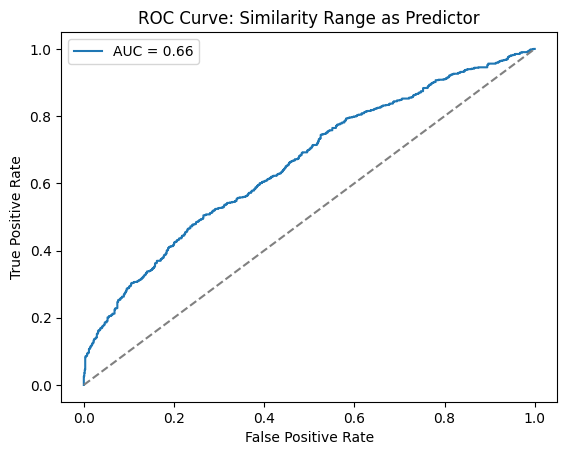

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_true = df2['IsCorrect'].astype(int)
y_score = df2['SimilarityRange']

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Similarity Range as Predictor')
plt.legend()
plt.show()


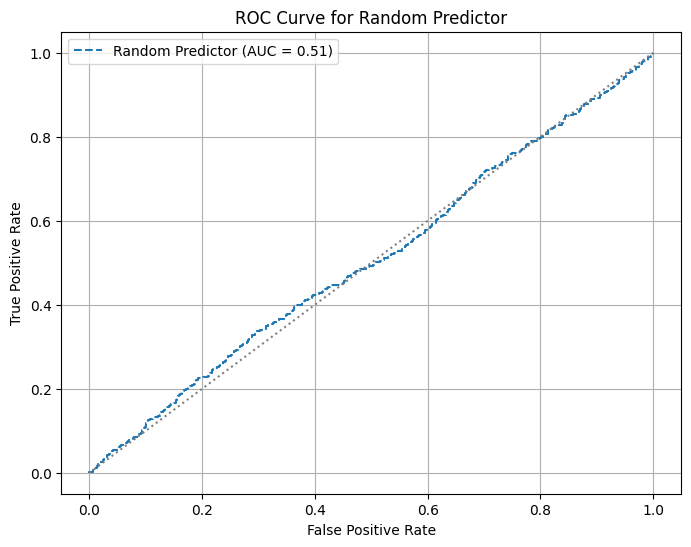

In [40]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# === Your actual labels ===
y_true = df2['IsCorrect'].astype(int).values

# === Random predictor ===
np.random.seed(42)  # for reproducibility
y_random = np.random.rand(len(y_true))  # random "score" between 0 and 1

# === Compute ROC ===
fpr_rand, tpr_rand, _ = roc_curve(y_true, y_random)
auc_rand = roc_auc_score(y_true, y_random)

# === Plot both ===
plt.figure(figsize=(8, 6))
plt.plot(fpr_rand, tpr_rand, label=f'Random Predictor (AUC = {auc_rand:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')  # perfect randomness reference
plt.title('ROC Curve for Random Predictor')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


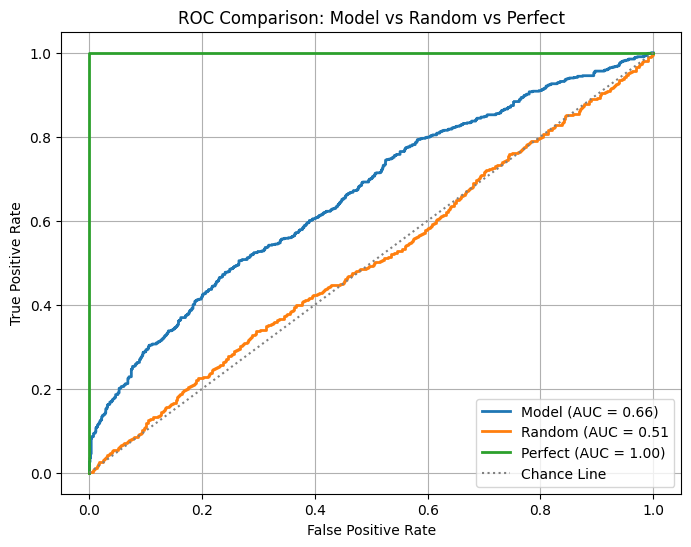

In [45]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# === Real model predictor ===
y_true = df2['IsCorrect'].astype(int).values
y_score = df2['SimilarityRange'].values
fpr_real, tpr_real, _ = roc_curve(y_true, y_score)
auc_real = roc_auc_score(y_true, y_score)

# === Random predictor ===
np.random.seed(42)
y_random = np.random.rand(len(y_true))
fpr_rand, tpr_rand, _ = roc_curve(y_true, y_random)
auc_rand = roc_auc_score(y_true, y_random)

# === Perfect predictor === (sorts true labels directly)
y_perfect = y_true  # sorted truth = perfect scores
fpr_perf, tpr_perf, _ = roc_curve(y_true, y_true)
auc_perf = roc_auc_score(y_true, y_true)

# === Plot all three ===
plt.figure(figsize=(8, 6))
plt.plot(fpr_real, tpr_real, label=f'Model (AUC = {auc_real:.2f})', linewidth=2)
plt.plot(fpr_rand, tpr_rand, label=f'Random (AUC = {auc_rand:.2f}', linewidth=2)
plt.plot(fpr_perf, tpr_perf, label='Perfect (AUC = 1.00)', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Chance Line')
plt.title('ROC Comparison: Model vs Random vs Perfect')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


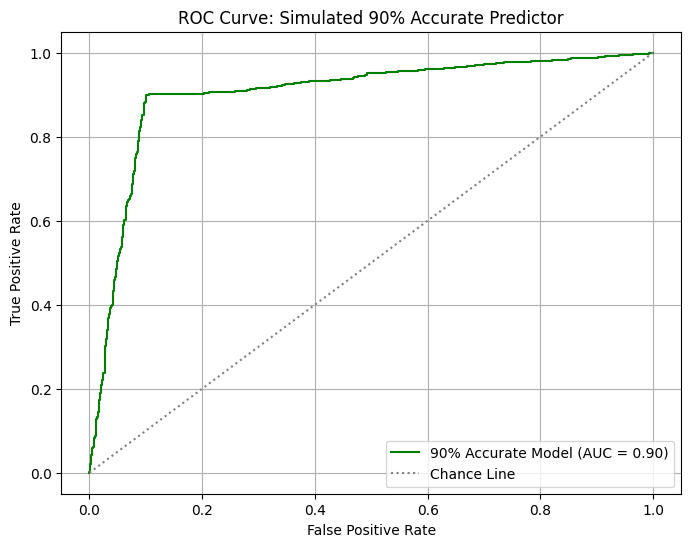

In [46]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# === Setup real labels ===
y_true = df2['IsCorrect'].astype(int).values
n = len(y_true)

# === Create a simulated 90% accurate score predictor ===
np.random.seed(42)
y_sim90 = np.zeros(n)

# Assign high scores to 90% of the correct ones, low scores to 90% of the incorrect ones
correct_idx = np.where(y_true == 1)[0]
incorrect_idx = np.where(y_true == 0)[0]

# 90% of correct get high scores
high_correct = np.random.choice(correct_idx, size=int(0.9 * len(correct_idx)), replace=False)
low_correct = np.setdiff1d(correct_idx, high_correct)

# 90% of incorrect get low scores
low_incorrect = np.random.choice(incorrect_idx, size=int(0.9 * len(incorrect_idx)), replace=False)
high_incorrect = np.setdiff1d(incorrect_idx, low_incorrect)

# Assign scores
y_sim90[high_correct] = np.random.uniform(0.7, 1.0, size=len(high_correct))
y_sim90[low_correct] = np.random.uniform(0.0, 0.3, size=len(low_correct))
y_sim90[high_incorrect] = np.random.uniform(0.7, 1.0, size=len(high_incorrect))
y_sim90[low_incorrect] = np.random.uniform(0.0, 0.3, size=len(low_incorrect))

# === Compute ROC for simulated model ===
fpr_sim, tpr_sim, _ = roc_curve(y_true, y_sim90)
auc_sim = roc_auc_score(y_true, y_sim90)

# === Plot it ===
plt.figure(figsize=(8, 6))
plt.plot(fpr_sim, tpr_sim, label=f'90% Accurate Model (AUC = {auc_sim:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Chance Line')
plt.title('ROC Curve: Simulated 90% Accurate Predictor')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


# NEW THING: Looking at the exceptions where alignment is right and MC prompting is wrong

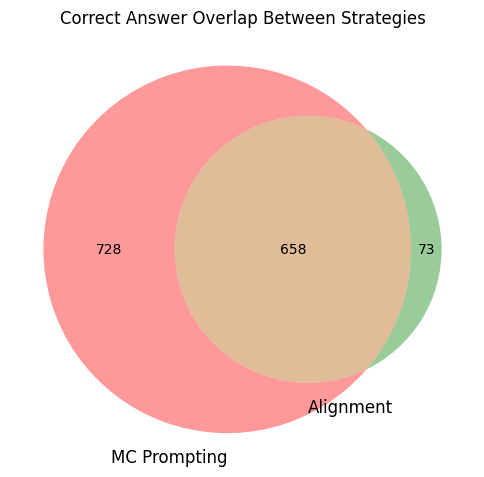

Alignment-only correct count: 73


In [5]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# === Load both results ===
mc_df    = pd.read_csv("output/cot.csv")
align_df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# === Preprocess text columns ===
for df, pfx in [(mc_df, "MC"), (align_df, "Align")]:
    df["Predicted"] = df["Predicted"].str.strip().str.upper()
    if pfx == "MC":
        df["OriginalCorrect"] = df["OriginalCorrect"].str.strip().str.upper()
    else:
        df["CorrectAnswer"] = df["CorrectAnswer"].str.strip().str.upper()

# === Parse similarity scores in align_df ===
#    Turn the string "[0.1, 0.2, …]" into a real Python list of floats.
align_df["SimilarityScores"] = align_df["SimilarityScores"].apply(ast.literal_eval)

# === Merge on question index ===
mc_df["OriginalIndex"] = mc_df.index
merged = pd.merge(
    mc_df,
    align_df,
    on="OriginalIndex",
    suffixes=("_MC", "_Align")
)

# === Compute per-row correctness booleans ===
merged["MC_Correct"]    = merged["Predicted_MC"]    == merged["OriginalCorrect"]
merged["Align_Correct"] = merged["Predicted_Align"] == merged["CorrectAnswer"]

# === Venn counts ===
only_mc    = ((merged["MC_Correct"])    & (~merged["Align_Correct"])).sum()
only_align = ((merged["Align_Correct"]) & (~merged["MC_Correct"])).sum()
both       = ((merged["MC_Correct"])    & ( merged["Align_Correct"])).sum()

# === Plot Venn Diagram ===
plt.figure(figsize=(6, 6))
venn2(subsets=(only_mc, only_align, both),
      set_labels=("MC Prompting", "Alignment"))
plt.title("Correct Answer Overlap Between Strategies")
plt.show()

# === Extract Alignment-only correct rows ===
align_only = merged[(merged["Align_Correct"]) & (~merged["MC_Correct"])]
print(f"Alignment-only correct count: {len(align_only)}")

# === Save to CSV (including raw SimilarityScores) ===
align_only.to_csv("output/align_right_mc_wrong_with_scores.csv", index=False)

# If you’d rather pick only certain columns, e.g.:
# cols = [
#     "OriginalIndex",
#     "Predicted_MC", "OriginalCorrect",
#     "Predicted_Align", "CorrectAnswer",
#     "SimilarityScores"
# ]
# align_only[cols].to_csv("output/align_right_mc_wrong_with_scores.csv", index=False)


In [7]:
df = pd.read_csv('output/align_right_mc_wrong_with_scores.csv')
df.columns

Index(['Unnamed: 0', 'OriginalIndex', 'RotationPosition', 'OriginalCorrect',
       'Question_MC', 'A_MC', 'B_MC', 'C_MC', 'D_MC', 'Predicted_MC',
       'RawOutput', 'Subject_MC', 'Subcategory_MC', 'Predicted_Align',
       'CorrectAnswer', 'SimilarityScores', 'FreeResponse', 'A_Align',
       'B_Align', 'C_Align', 'D_Align', 'Question_Align', 'Subject_Align',
       'Subcategory_Align', 'MC_Correct', 'Align_Correct'],
      dtype='object')

<Figure size 700x500 with 0 Axes>

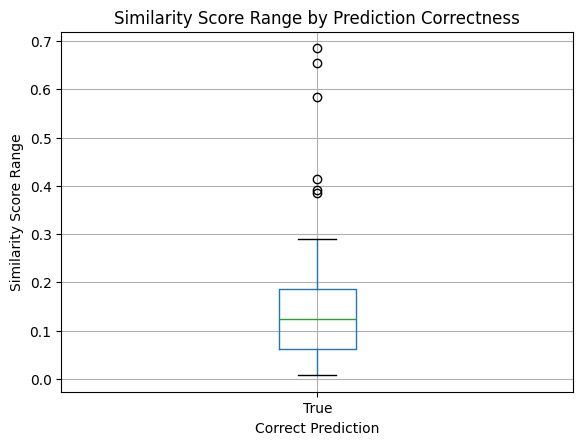

In [8]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# === Load the CSV you just generated ===
df = pd.read_csv("output/align_right_mc_wrong_with_scores.csv")

# === Make sure your text columns are normalized ===
df["Predicted_Align"] = df["Predicted_Align"].str.strip().str.upper()
df["CorrectAnswer"]   = df["CorrectAnswer"].str.strip().str.upper()

# === Compute a simple correctness flag ===
df["IsCorrect"] = df["Predicted_Align"] == df["CorrectAnswer"]

# === Parse out the list of floats from the string, then compute range ===
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)
df["SimilarityRange"] = df["SimilarityScores"].apply(lambda s: max(s) - min(s))

# === Box-plot of range by correctness ===
plt.figure(figsize=(7, 5))
df.boxplot(column="SimilarityRange", by="IsCorrect", grid=True)
plt.title("Similarity Score Range by Prediction Correctness")
plt.suptitle("")     # remove the automatic “Boxplot grouped by …” subtitle
plt.xlabel("Correct Prediction")
plt.ylabel("Similarity Score Range")
plt.show()


Number of Top2Gap values > 0.1: 13


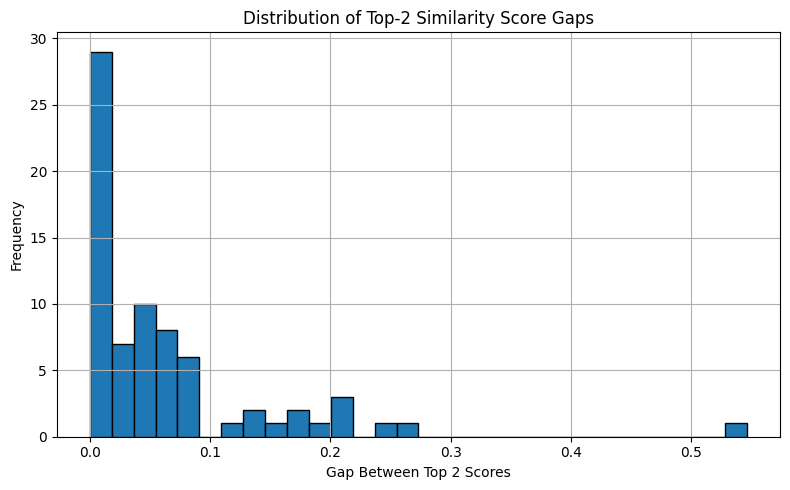

In [10]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# === Load the CSV with raw SimilarityScores ===
df = pd.read_csv("output/align_right_mc_wrong_with_scores.csv")

# === Parse the stringified lists into real Python lists ===
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)

# === Compute gap between highest and second-highest score ===
df["Top2Gap"] = df["SimilarityScores"].apply(
    lambda s: sorted(s, reverse=True)[0] - sorted(s, reverse=True)[1]
)

# === Count how many gaps > 0.1 ===
count_gt_01 = (df["Top2Gap"] > 0.1).sum()
print(f"Number of Top2Gap values > 0.1: {count_gt_01}")

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(df["Top2Gap"], bins=30, edgecolor="black")
plt.title("Distribution of Top-2 Similarity Score Gaps")
plt.xlabel("Gap Between Top 2 Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
13 / 1700

0.007647058823529412

# With the new method of generation

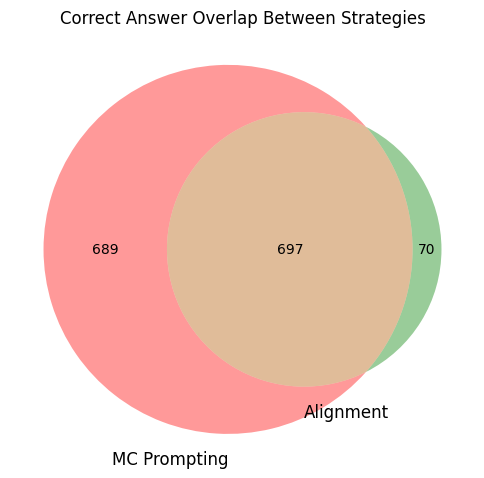

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# === Load both results ===
mc_df = pd.read_csv("output/cot.csv")
align_df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# === Preprocess ===
mc_df["Predicted"] = mc_df["Predicted"].str.strip().str.upper()
mc_df["OriginalCorrect"] = mc_df["OriginalCorrect"].str.strip().str.upper()
align_df["Predicted"] = align_df["Predicted"].str.strip().str.upper()
align_df["CorrectAnswer"] = align_df["CorrectAnswer"].str.strip().str.upper()

# === Merge on question index ===
mc_df["OriginalIndex"] = mc_df.index
merged = pd.merge(mc_df, align_df, on="OriginalIndex", suffixes=("_MC", "_Align"))

# === Evaluate Accuracy ===
merged["MC_Correct"] = merged["Predicted_MC"] == merged["OriginalCorrect"]
merged["Align_Correct"] = merged["Predicted_Align"] == merged["CorrectAnswer"]

# === Set counts for Venn
only_mc = ((merged["MC_Correct"]) & (~merged["Align_Correct"])).sum()
only_align = ((merged["Align_Correct"]) & (~merged["MC_Correct"])).sum()
both = ((merged["MC_Correct"]) & (merged["Align_Correct"])).sum()

# === Plot Venn Diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(only_mc, only_align, both), set_labels=("MC Prompting", "Alignment"))
plt.title("Correct Answer Overlap Between Strategies")
plt.show()


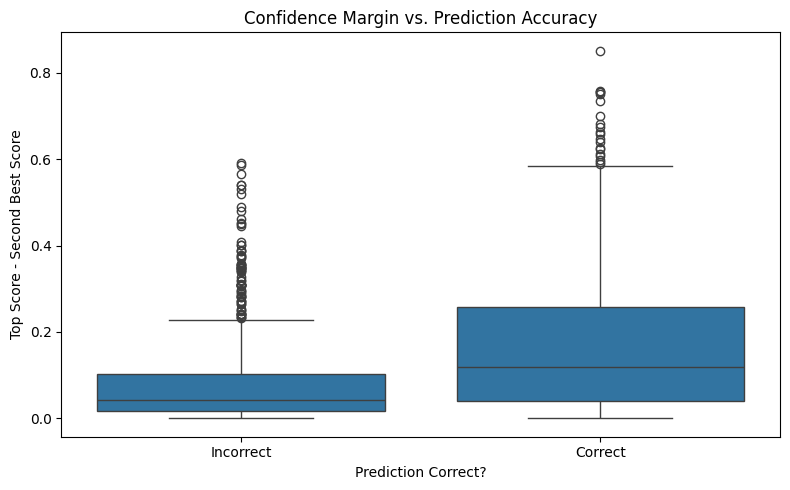

Average Confidence Margin (Correct): 0.17528896869889993
Average Confidence Margin (Incorrect): 0.07802471965112168


In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your output file ===
df = pd.read_csv("output/alignment_eval_mistral-small_en.csv")

# === Normalize columns ===
df["Predicted"] = df["Predicted"].str.strip().str.upper()
df["CorrectAnswer"] = df["CorrectAnswer"].str.strip().str.upper()
df["IsCorrect"] = df["Predicted"] == df["CorrectAnswer"]

# === Parse Similarity Scores ===
df["SimilarityScores"] = df["SimilarityScores"].apply(ast.literal_eval)

# === Compute metrics ===
df["TopScore"] = df["SimilarityScores"].apply(max)
df["TopIndex"] = df["SimilarityScores"].apply(lambda s: s.index(max(s)))
df["SecondScore"] = df["SimilarityScores"].apply(lambda s: sorted(s, reverse=True)[1])
df["ConfidenceMargin"] = df["TopScore"] - df["SecondScore"]

# === Distribution of Confidence by Correctness ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="IsCorrect", y="ConfidenceMargin")
plt.title("Confidence Margin vs. Prediction Accuracy")
plt.xlabel("Prediction Correct?")
plt.ylabel("Top Score - Second Best Score")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.tight_layout()
plt.show()

# === Optional: Print correlation
print("Average Confidence Margin (Correct):", df[df["IsCorrect"] == True]["ConfidenceMargin"].mean())
print("Average Confidence Margin (Incorrect):", df[df["IsCorrect"] == False]["ConfidenceMargin"].mean())


In [3]:
threshold = 0.4524092674256
confident = df[df["ConfidenceMargin"] > threshold]
print("Accuracy on confident predictions:", confident["IsCorrect"].mean())
print("Coverage (fraction of data kept):", len(confident) / len(df))
print(len(confident))


Accuracy on confident predictions: 0.8809523809523809
Coverage (fraction of data kept): 0.04941176470588235
84


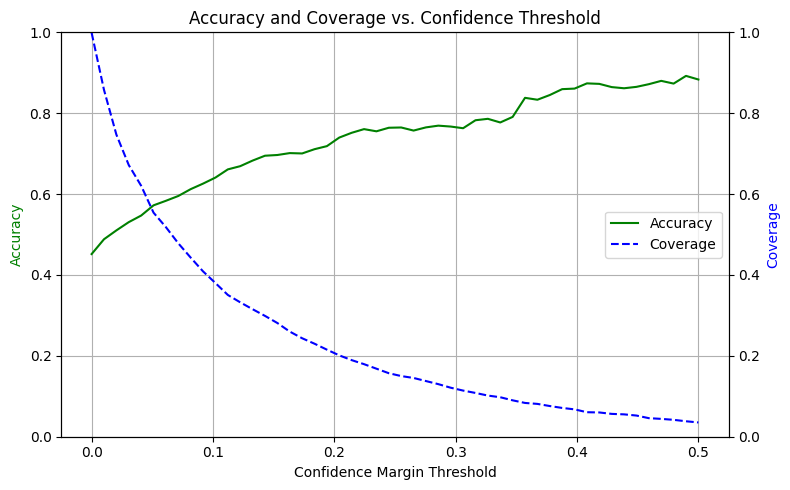

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of thresholds
thresholds = np.linspace(0, 0.5, 50)
accuracies = []
coverages = []

for t in thresholds:
    confident = df[df["ConfidenceMargin"] > t]
    if len(confident) == 0:
        acc = np.nan
    else:
        acc = confident["IsCorrect"].mean()
    accuracies.append(acc)
    coverages.append(len(confident) / len(df))

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax2 = ax1.twinx()
ax1.plot(thresholds, accuracies, color='green', label="Accuracy")
ax2.plot(thresholds, coverages, color='blue', linestyle='--', label="Coverage")

ax1.set_xlabel("Confidence Margin Threshold")
ax1.set_ylabel("Accuracy", color='green')
ax2.set_ylabel("Coverage", color='blue')

# Set both y-axis limits to 0–1.0
ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)

ax1.set_title("Accuracy and Coverage vs. Confidence Threshold")
ax1.grid(True)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()
